In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
data = pd.read_csv('day.csv')

# Display basic information about the dataset
print("Dataset Info:")
print(data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
None


In [5]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())



Missing Values:
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [7]:
# Check for duplicates
print("\nDuplicate Rows:", data.duplicated().sum())


Duplicate Rows: 0


In [9]:
# Basic statistical summary
print("\nNumerical Features Summary:")
print(data.describe())


Numerical Features Summary:
          instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.997260   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.006161   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.250000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.683562    1.394521   20.319259   23.726322   62.765175   12.763620  

In [11]:

# 2.1 Convert categorical variables to string
# As mentioned in the assignment, variables like 'weathersit' and 'season' 
# should be treated as categorical
categorical_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 
                      'workingday', 'weathersit']
print("\nUnique values in categorical columns:")
for col in categorical_columns:
    print(f"\n{col}:", data[col].unique())


Unique values in categorical columns:

season: [1 2 3 4]

yr: [0 1]

mnth: [ 1  2  3  4  5  6  7  8  9 10 11 12]

holiday: [0 1]

weekday: [6 0 1 2 3 4 5]

workingday: [0 1]

weathersit: [2 1 3]


In [13]:
# 2.1 Create derived metrics
# Temperature feels-like difference
data['temp_diff'] = data['temp'] - data['atemp']

# Create season names for better interpretation
season_map = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
data['season_name'] = data['season'].map(season_map)

# Create month names
data['month_name'] = pd.to_datetime(data['mnth'], format='%m').dt.strftime('%B')

In [15]:
# 2.2 Handle categorical variables
# Convert to category type for efficiency
for col in categorical_columns:
    data[col] = data[col].astype('category')

# Create dummy variables with descriptive names
data_encoded = pd.get_dummies(data[categorical_columns], 
                             prefix=categorical_columns,
                             drop_first=True)
# Using drop_first=True as specified in the assignment question
data_encoded = pd.get_dummies(data[categorical_columns], 
                             prefix=categorical_columns,
                             drop_first=True)

# 2.3 Scale numerical features
numerical_features = ['temp', 'atemp', 'hum', 'windspeed', 'temp_diff']
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])


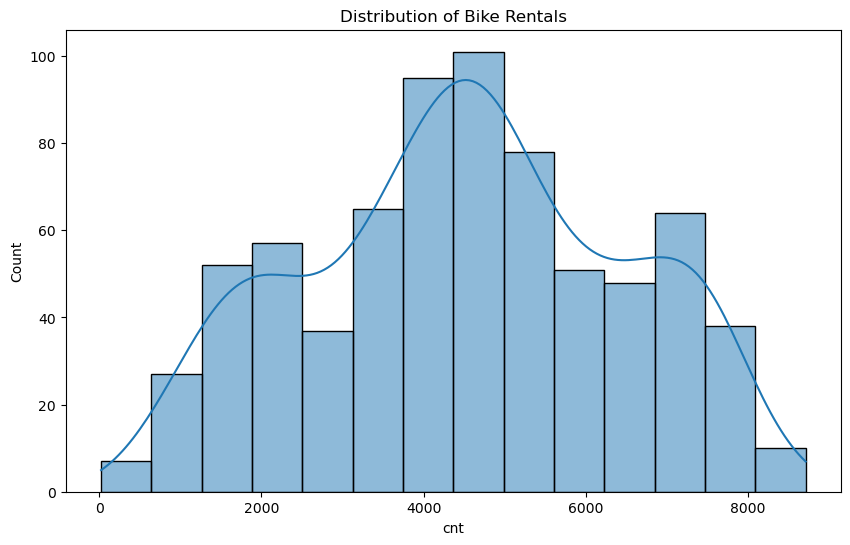

In [17]:
# 3.1 Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(data['cnt'], kde=True)
plt.title('Distribution of Bike Rentals')
plt.show()

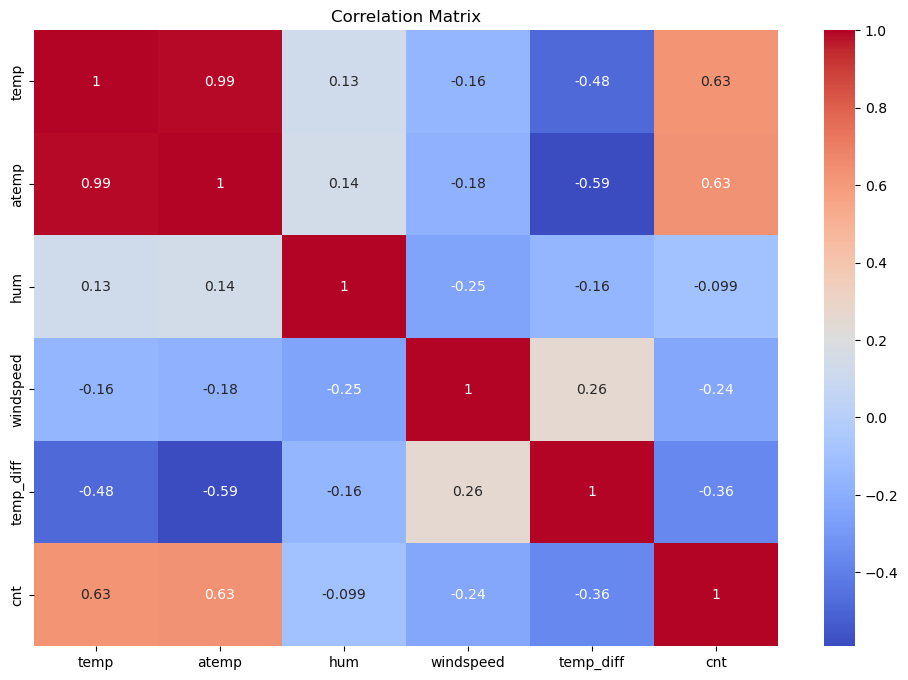

In [19]:
# 3.2 Correlation analysis
plt.figure(figsize=(12, 8))
correlation_matrix = data[numerical_features + ['cnt']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

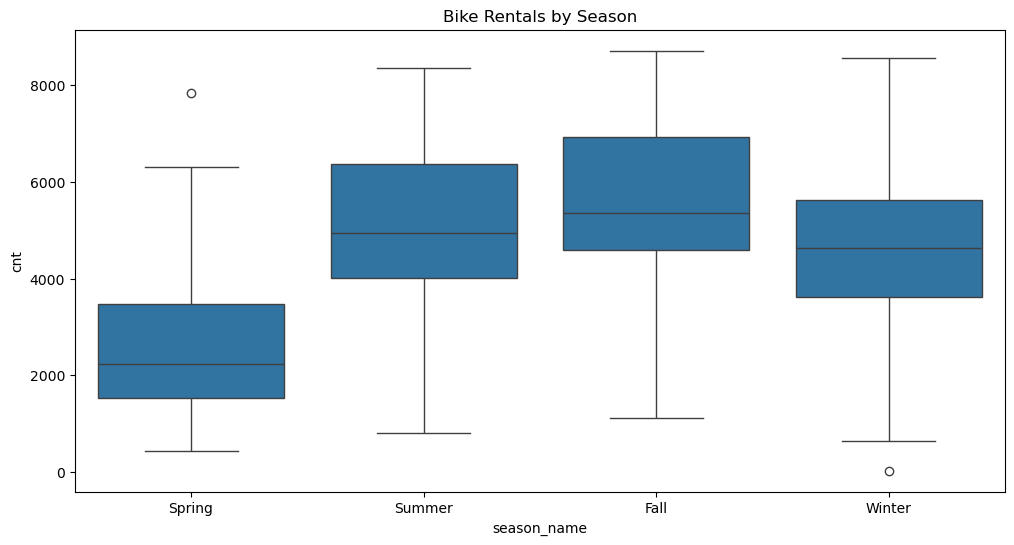

In [21]:
# 3.3 Seasonal patterns
plt.figure(figsize=(12, 6))
sns.boxplot(x='season_name', y='cnt', data=data)
plt.title('Bike Rentals by Season')
plt.show()


In [23]:
# 4.1 Prepare features for modeling
X = pd.concat([data[numerical_features], data_encoded], axis=1)
y = data['cnt']


In [25]:
# 4.2 Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [27]:
# 4.3 Feature selection using RFE
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]

In [29]:
# 4.4 Model training with different approaches
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0)
}

model_scores = {}
for name, model in models.items():
    # Train model
    model.fit(X_train[selected_features], y_train)
    # Make predictions
    y_pred = model.predict(X_test[selected_features])
    # Calculate scores
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    model_scores[name] = {'R2': r2, 'RMSE': rmse}

print("\nModel Performance Comparison:")
for name, scores in model_scores.items():
    print(f"\n{name}:")
    print(f"R2 Score: {scores['R2']:.4f}")
    print(f"RMSE: {scores['RMSE']:.4f}")



Model Performance Comparison:

Linear Regression:
R2 Score: 0.8447
RMSE: 729.0687

Ridge Regression:
R2 Score: 0.8428
RMSE: 733.5963

Lasso Regression:
R2 Score: 0.8453
RMSE: 727.5673


In [31]:
# Select best model (assuming Linear Regression performs best)
final_model = models['Linear Regression']
final_model.fit(X_train[selected_features], y_train)

LinearRegression()

In [33]:
# Make predictions
y_pred = final_model.predict(X_test[selected_features])

# 5.1 Residual Analysis
residuals = y_test - y_pred

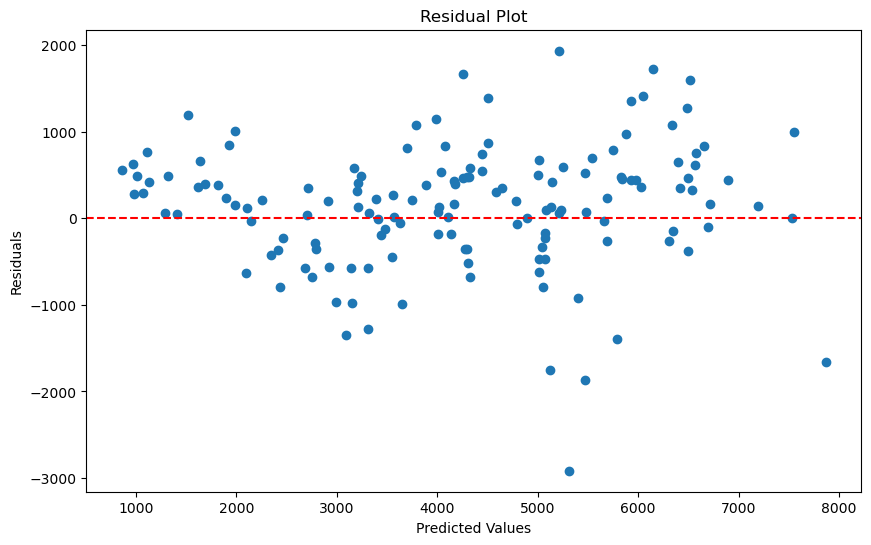

In [35]:
# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

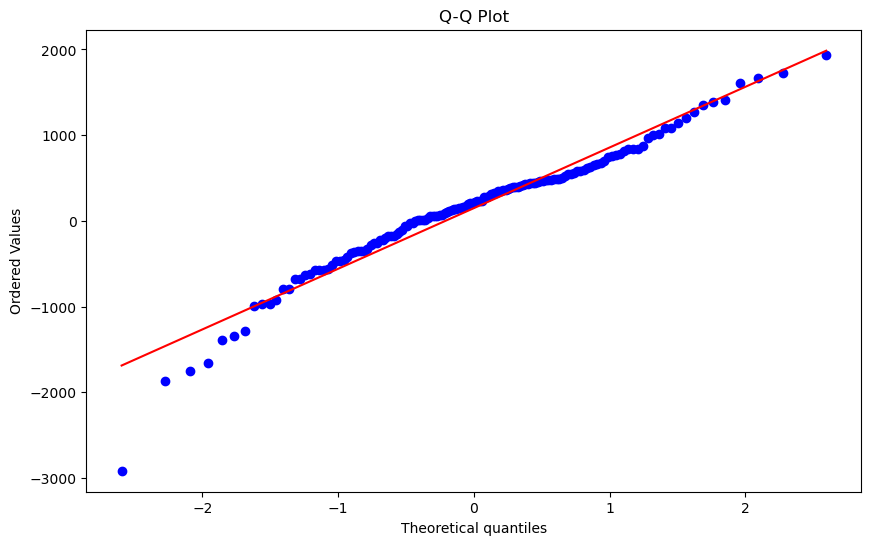

In [37]:
# Q-Q plot for normality check
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

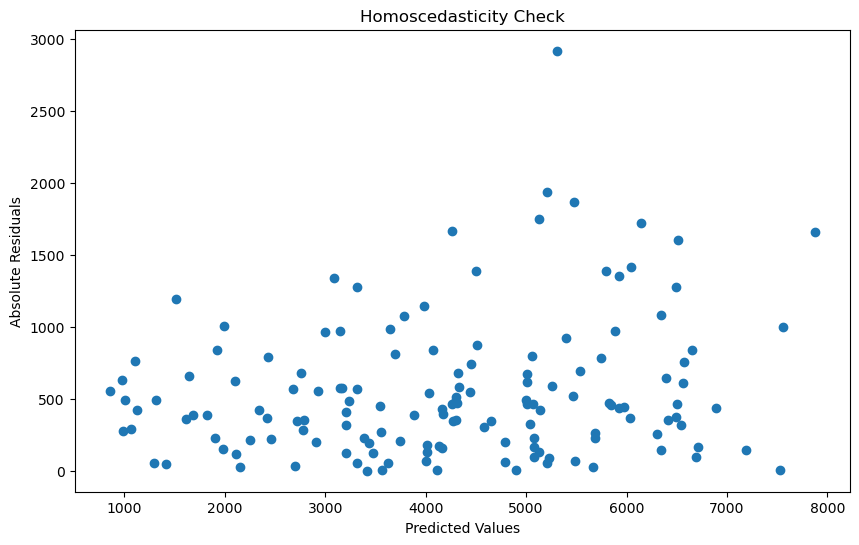

In [39]:
# Homoscedasticity check
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, np.abs(residuals))
plt.xlabel('Predicted Values')
plt.ylabel('Absolute Residuals')
plt.title('Homoscedasticity Check')
plt.show()

In [41]:
#############################################
# 6. Model Interpretation
#############################################

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': final_model.coef_
})
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', 
                                                  ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Model assumptions summary
print("\nModel Assumptions Check:")
print("1. Linearity: Check residual plot for patterns")
print("2. Normality: Check Q-Q plot for alignment with diagonal")
print("3. Homoscedasticity: Check residual plot for constant variance")
print("4. Independence: Assumed based on data collection method")

# Save model performance metrics
with open('model_performance.txt', 'w') as f:
    f.write(f"R-squared Score: {r2_score(y_test, y_pred):.4f}\n")
    f.write(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}\n")


Top 10 Most Important Features:
        Feature  Coefficient  Abs_Coefficient
0          temp  3243.294880      3243.294880
2           hum -2397.252163      2397.252163
1         atemp  2067.904280      2067.904280
6          yr_1  1920.361537      1920.361537
3     windspeed -1581.049321      1581.049321
9  weathersit_3 -1558.485208      1558.485208
5      season_4  1285.415278      1285.415278
7        mnth_9   927.974620       927.974620
4      season_2   791.742224       791.742224
8     holiday_1  -694.781401       694.781401

Model Assumptions Check:
1. Linearity: Check residual plot for patterns
2. Normality: Check Q-Q plot for alignment with diagonal
3. Homoscedasticity: Check residual plot for constant variance
4. Independence: Assumed based on data collection method


In [43]:
# 7. Conclusions
#############################################

print("\nModel Conclusions:")
print("1. Most Significant Variables:")
print(feature_importance.head(5).to_string())
print("\n2. Model Performance:")
print(f"   R-squared Score: {r2:.4f}")
print("\n3. Model Assumptions Check:")
print("   - Check the residual plot for homoscedasticity")
print("   - Check the Q-Q plot for normality of residuals")

# Save feature importance for later analysis
feature_importance.to_csv('feature_importance.csv', index=False)


Model Conclusions:
1. Most Significant Variables:
     Feature  Coefficient  Abs_Coefficient
0       temp  3243.294880      3243.294880
2        hum -2397.252163      2397.252163
1      atemp  2067.904280      2067.904280
6       yr_1  1920.361537      1920.361537
3  windspeed -1581.049321      1581.049321

2. Model Performance:
   R-squared Score: 0.8453

3. Model Assumptions Check:
   - Check the residual plot for homoscedasticity
   - Check the Q-Q plot for normality of residuals
